In [1]:
%matplotlib inline
from ast import literal_eval
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from typing import Tuple
import numpy as np

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from scipy.stats import norm

import warnings

from lob_data_utils import lob, db_result

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [24]:
r=0.01
s=0.02

K = 50
gdf_columns = ['gdf_' + str(i) for i in range(0, K)]
gdfs_r = r * np.ones(K)
gdfs_m = 0.1000 * np.hstack([np.arange(- K // 2, 0), np.arange(1, K // 2 + 1)])
gdfs_s = s * np.ones(K)
gdfs = np.vstack([gdfs_r, gdfs_m, gdfs_s]).T

def gdf_representation(buy_orders, sell_orders, gdf):
    buy_price, buy_volume = buy_orders
    sell_price, sell_volume = sell_orders
    buy_gdf_y = gdf[0] * norm.pdf(buy_price, loc=gdf[1], scale=gdf[2])
    sell_gdf_y = gdf[0] * norm.pdf(sell_price, loc=gdf[1], scale=gdf[2])
    return np.clip(buy_volume, 0.0, buy_gdf_y).sum() + np.clip(sell_volume, 0.0, sell_gdf_y).sum()

In [3]:
def transform_to_orders(df: pd.DataFrame) -> pd.DataFrame:
    order_list = []
    for idx, row in df.iterrows():
        l_bid = [literal_eval(row.get('bid'))][0]
        bid_dict = [{'price': p, 'volume': v} for p, v in l_bid]
        d_bid = pd.DataFrame(bid_dict, columns=['price', 'volume'])
#         d_bid = d_bid.sort_values(by='price', ascending=False) #.iloc[0:n]
#         d_bid = d_bid.sort_values(by='price', ascending=True)
#         d_bid.index = list(range(0, len(d_bid)))
#         d_bid.reindex()
        
        l_ask = [literal_eval(row.get('ask'))][0]
        ask_dict = [{'price': p, 'volume': v} for p, v in l_ask]
        d_ask = pd.DataFrame(ask_dict, columns=['price', 'volume'])
#         d_ask = d_ask.sort_values(by='price', ascending=True)# .iloc[0:n]

        mid_price = row['mid_price']
        
        d_bid['volume_norm'] = d_bid['volume'] * d_bid['price']
        d_ask['volume_norm'] = d_ask['volume'] * d_ask['price']
        
        total_capital = d_bid['volume_norm'].sum() + d_ask['volume_norm'].sum()
        d_bid['volume_norm'] /= total_capital
        d_ask['volume_norm'] /= total_capital
        
        d_bid['price_norm'] = 1000 * (d_bid['price'] - mid_price) / mid_price
        d_ask['price_norm'] = 1000 * (d_ask['price'] - mid_price) / mid_price

        new_row_dict = {}
        for i in range(0, K):
            p = K/(len(d_bid) + len(d_ask)) 

            idx = int(np.floor(p*len(d_bid) - K//2 + i))
            
            gdf_repr = gdf_representation((d_bid['price_norm'], d_bid['volume_norm']), 
                                          (d_ask['price_norm'], d_ask['volume_norm']), 
                                          gdfs[i, :])
            new_row_dict['gdf_' + str(i)] = gdf_repr
            new_row_dict['ask_vol' + str(i)] = d_ask.iloc[idx]['volume_norm']
            new_row_dict['ask_p' + str(i)] = d_ask.iloc[idx]['price_norm']
            new_row_dict['bid_vol' + str(i)] = d_bid.iloc[idx]['volume_norm']
            new_row_dict['bid_p' + str(i)] = d_bid.iloc[idx]['price_norm']
        new_row_dict['mid_price'] = row.get('mid_price')
        new_row_dict['mid_price_indicator'] = row.get('mid_price_indicator')
        
        order_list.append(new_row_dict)
    order_df = pd.DataFrame(order_list)
    return order_df

In [4]:
data_length = 5050

dfs = {}
dfs_test = {}
dfs_cv = {}

stocks = ['9061', '9062', '9063', '9064', '9065']

for s in stocks:
    d, d_cv, d_test = lob.load_prepared_data(s, data_dir='data/', cv=True, length=data_length)
    dfs[s] = transform_to_orders(d)
    dfs_cv[s] = transform_to_orders(d_cv)

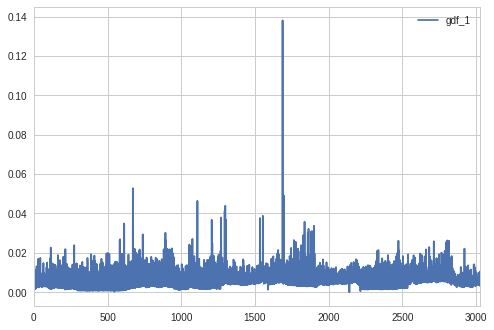

In [5]:
dfs['9061'][['gdf_1']].plot()

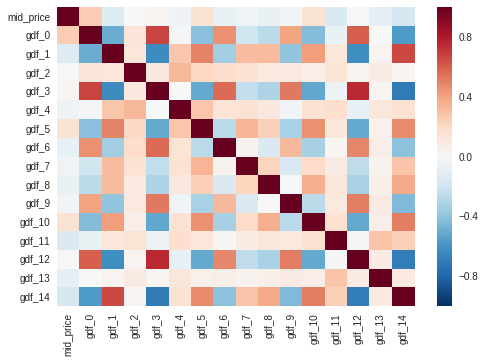

In [6]:
sns.heatmap(dfs['9061'][['mid_price'] + gdf_columns].corr())

In [7]:
def svm_classification(df):
    clf = SVC(probability=True, C=10000)        
    X = df[gdf_columns]
    print(X.shape)

    y = df['mid_price_indicator'].values.reshape(-1, 1)
    y[0] = 0
    print(y.shape)
    clf.fit(X, y)
    return clf

In [8]:
clfs = {}
for s in stocks:
    print('**************************************', s)
    try:
        clf = svm_classification(dfs[s])
        clfs[s] = clf
        predictions = clf.predict(dfs[s][gdf_columns])
        print(s, roc_auc_score(predictions, dfs[s]['mid_price_indicator']))
    except Exception as e:
        print(e)

************************************** 9061
(3030, 15)
(3030, 1)
9061 0.552256509262
************************************** 9062
(3030, 15)
(3030, 1)
9062 0.554352244937
************************************** 9063
(3030, 15)
(3030, 1)
9063 0.556828142466
************************************** 9064
(3030, 15)
(3030, 1)
9064 0.555157211635
************************************** 9065
(3030, 15)
(3030, 1)
9065 0.569251044883


In [9]:
for s in stocks:
    print('****************************************', s)
    predictions_cv = clfs[s].predict(dfs_cv[s].loc[:, gdf_columns])
    try:
        print(s, roc_auc_score(predictions_cv, dfs_cv[s]['mid_price_indicator']))
    except Exception as e:
        print(s, e)

**************************************** 9061
9061 0.554925077783
**************************************** 9062
9062 0.521821800476
**************************************** 9063
9063 0.523438301154
**************************************** 9064
9064 0.547193347193
**************************************** 9065
9065 0.544073759935


In [10]:
for s in stocks:
    d, d_cv, d_test = lob.load_prepared_data(s, data_dir='data/', cv=True, length=data_length)
    dfs_test[s] = transform_to_orders(d_test)

In [11]:
for s in stocks:
    predictions_test = clfs[s].predict(dfs_test[s].loc[:, gdf_columns])
    try:
        print(s, roc_auc_score(predictions_test, dfs_test[s]['mid_price_indicator']))
    except Exception as e:
        print(s, e)

9061 0.519836034678
9062 0.547743485073
9063 0.521639823776
9064 0.538499592597
9065 0.559000753201


# Blabla

In [29]:
s='9061'
d, d_cv, d_test = lob.load_prepared_data(s, data_dir='data/', cv=True, length=data_length)

In [30]:
d.head()

,Unnamed: 0,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
1010,2013-09-05 09:26:00,"[(523.0, 1000.0), (550.0, 6364.0), (615.0, 363...","[(704.9, 9714.0), (705.0, 33868.0), (705.1, 22...",704.6,704.9,704.75,9714.0,6385.0,0.0,-0.206783
1011,2013-09-05 09:27:00,"[(523.0, 1000.0), (550.0, 6364.0), (615.0, 363...","[(704.6, 5730.0), (704.7, 10848.0), (704.8, 20...",704.3,704.6,704.45,5730.0,10614.0,1.0,0.298825
1012,2013-09-05 09:28:00,"[(523.0, 1000.0), (550.0, 6364.0), (615.0, 363...","[(704.6, 7209.0), (704.7, 18769.0), (704.8, 19...",704.4,704.6,704.50,7209.0,2470.0,0.0,-0.489617
1013,2013-09-05 09:29:00,"[(523.0, 1000.0), (550.0, 6364.0), (615.0, 363...","[(704.3, 5263.0), (704.4, 17973.0), (704.5, 19...",704.0,704.3,704.15,5263.0,4859.0,1.0,-0.039913
1014,2013-09-05 09:30:00,"[(523.0, 1000.0), (550.0, 6364.0), (615.0, 363...","[(704.5, 13440.0), (704.6, 20454.0), (704.7, 1...",704.2,704.5,704.35,13440.0,6156.0,1.0,-0.371709


In [31]:
i = 0
print(len(d.iloc[i]['bid']))
print(len(d.iloc[i]['ask']))
print(d.iloc[i]['mid_price'])

1436
1480
704.75


In [32]:
bid = [{'price': b[0], 'volume': b[1]} for b in literal_eval(d.iloc[i]['bid'])]
df_bid = pd.DataFrame(bid)
df_bid = df_bid.sort_values(by='price', ascending=False)#.iloc[0:20]
df_bid = df_bid.sort_values(by='price', ascending=True)

df_bid.index = list(range(0, len(df_bid)))
df_bid.reindex()
df_bid.head()

,price,volume
0,523.0,1000.0
1,550.0,6364.0
2,615.0,3635.0
3,630.0,15108.0
4,631.0,1836.0


In [33]:
ask = [{'price': b[0], 'volume': b[1]} for b in literal_eval(d.iloc[i]['ask'])]
df_ask = pd.DataFrame(ask)
df_ask = df_ask.sort_values(by='price', ascending=True)#.iloc[0:20]
df_ask.head()

,price,volume
0,704.9,9714.0
1,705.0,33868.0
2,705.1,22812.0
3,705.2,12079.0
4,705.3,20674.0


In [34]:
mid_price = d.iloc[i]['mid_price']
df_bid['volume_norm'] = df_bid['volume'] * df_bid['price']
df_ask['volume_norm'] = df_ask['volume'] * df_ask['price']

total_capital = df_bid['volume_norm'].sum() + df_ask['volume_norm'].sum()
df_bid['volume_norm'] /= total_capital
df_ask['volume_norm'] /= total_capital

df_bid['price_norm'] = 1000 * (df_bid['price'] - mid_price) / mid_price
df_ask['price_norm'] = 1000 * (df_ask['price'] - mid_price) / mid_price

In [35]:
df_bid[['price_norm', 'volume_norm']]

,price_norm,volume_norm
0,-257.892870,0.000442
1,-219.581412,0.002955
2,-127.350124,0.001887
3,-106.065981,0.008035
4,-104.647038,0.000978
5,-103.228095,0.001267
6,-98.971266,0.008149
7,-93.295495,0.001349
8,-91.876552,0.004701
9,-89.038666,0.004336


In [36]:
gdf_representation((df_bid['price_norm'], df_bid['volume_norm']),
                   (df_ask['price_norm'], df_ask['volume_norm']), gdfs[0, :])

0.007600799941518358

In [37]:
import lobs_plots
% matplotlib inline

import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

from ipywidgets import interact, interactive, fixed, interact_manual, widgets
gdf_features = [gdf_representation((df_bid['price_norm'], df_bid['volume_norm']),
                   (df_ask['price_norm'], df_ask['volume_norm']), gdfs[j, :]) for j in range(0, K)]
lobs_plots.plot_gdf_features(gdf_features)

In [38]:
buy_orders = np.array(list(zip(df_bid['price_norm'].values, df_bid['volume_norm'].values)))
sell_orders = np.array(list(zip(df_ask['price_norm'].values, df_ask['volume_norm'].values)))

print(len(buy_orders), len(sell_orders))
p = K/(len(buy_orders) + len(sell_orders)) 
ss = len(buy_orders) / (len(buy_orders)  + len(sell_orders))

print(p*len(buy_orders))

lobs_plots.plot_lob_and_gdf(buy_orders, sell_orders, gdfs[13, :], K)

83 86
7.366863905325443
